# 11. CHICAGO AIRBNB: OUTLIERS' EFFECT
---

## 1. The Data

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 999)
pd.set_option('precision', 3)

chic_cols = ['accommodates', 'bedrooms', 'baths', 'beds', 
             'min_nights', 'max_nights', 'n_reviews', 'price']
chicago = pd.read_csv('data/chicago_airbnb1')
chicago = chicago[chic_cols].copy()
print(chicago.shape)
chicago.head()

(6550, 8)


,accommodates,bedrooms,baths,beds,min_nights,max_nights,n_reviews,price
0,1,1.0,0.5,1.0,2,90,178,66.0
1,7,3.0,1.0,5.0,2,60,395,94.0
2,2,1.0,1.0,1.0,2,60,384,61.0
3,4,1.0,1.0,0.0,4,180,49,67.0
4,2,1.0,0.5,1.0,1,1125,44,22.0


In [2]:
chicago.isnull().sum()

accommodates      0
bedrooms        522
baths             6
beds             37
min_nights        0
max_nights        0
n_reviews         0
price             0
dtype: int64

## 2. Handling Missing Data

In [3]:
chicago.groupby(['accommodates'])['baths'].value_counts(dropna=False).head(12)

accommodates  baths
0             NaN         1
1             0.50      202
              1.00      163
              0.75       30
              2.00       14
              1.50       12
              1.25        4
              11.00       3
              0.00        2
              0.25        2
              2.50        2
2             1.00     1392
Name: baths, dtype: int64

In [4]:
mode = chicago['baths'].mode()[0]
chicago['baths'] = chicago.groupby(['accommodates'])['baths'].\
apply(lambda x:x.fillna(x.value_counts().idxmax() 
                        if x.value_counts().max() >=1
                       else mode , inplace = False
                       )
     )
chicago['baths'].isnull().sum()

0

In [5]:
chicago.groupby(['accommodates', 'baths'])['beds'].value_counts(dropna=False).head(12)

accommodates  baths  beds
0             1.00   NaN       1
1             0.00   1.0       1
                     2.0       1
              0.25   0.0       1
                     1.0       1
              0.50   1.0     186
                     2.0       7
                     0.0       6
                     NaN       1
                     3.0       1
                     4.0       1
              0.75   1.0      27
Name: beds, dtype: int64

In [6]:
mode = chicago['beds'].mode()[0]
chicago['beds'] = chicago.groupby(['accommodates', 'baths'])['beds'].\
apply(lambda x:x.fillna(x.value_counts().idxmax() 
                        if x.value_counts().max() >=1
                       else mode , inplace = False
                       )
     )
chicago['beds'].isnull().sum()

0

In [7]:
mode = chicago['bedrooms'].mode()[0]
chicago['bedrooms'] = chicago.groupby(['accommodates', 'beds', 'baths'])['bedrooms'].\
apply(lambda x:x.fillna(x.value_counts().idxmax() 
                        if x.value_counts().max() >=1
                       else mode , inplace = False
                       )
     )
chicago['bedrooms'].isnull().sum()

0

In [8]:
chicago.isnull().sum()

accommodates    0
bedrooms        0
baths           0
beds            0
min_nights      0
max_nights      0
n_reviews       0
price           0
dtype: int64

## 3. Exploring Outliers

In [9]:
chicago.max() - chicago.min()

accommodates       16.0
bedrooms           11.0
baths              12.5
beds               30.0
min_nights        499.0
max_nights       8999.0
n_reviews         627.0
price           10000.0
dtype: float64

While it's tempting to leave our target attribute (`price`) untached, it's important to know that if we do it, it will lead to our model wanting reproduce the outlier effect. So let's first normalize the data and cap outliers and then observe the difference

In [10]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler()
chicago_1 = normalizer.fit_transform(chicago)
chicago_1 = pd.DataFrame(chicago_1)
chicago_1.columns = chic_cols
chicago_1.head()

,accommodates,bedrooms,baths,beds,min_nights,max_nights,n_reviews,price
0,0.062,0.000,0.04,0.033,0.002,0.010,0.284,0.007
1,0.438,0.182,0.08,0.167,0.002,0.007,0.630,0.009
2,0.125,0.000,0.08,0.033,0.002,0.007,0.612,0.006
3,0.250,0.000,0.08,0.000,0.006,0.020,0.078,0.007
4,0.125,0.000,0.04,0.033,0.000,0.125,0.070,0.002


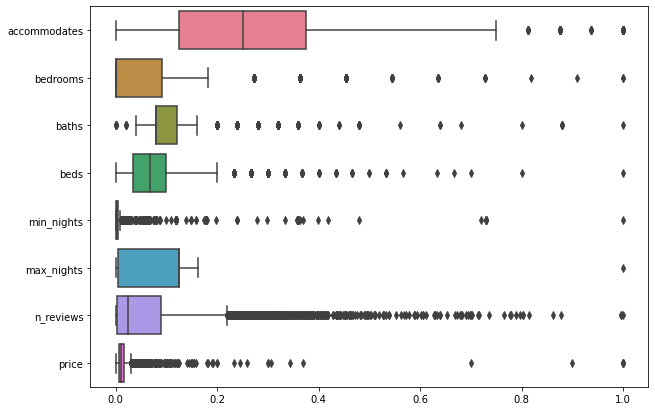

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
ax = sns.boxplot(data=chicago_1, orient="h", palette="husl")

## 4. Capping Outliers

In [12]:
def cap_outliers(df, cols):
    df = df.copy()
    IQR = df.quantile(0.75) - df.quantile(0.25)
    LB = df.quantile(0.25) - (IQR*1.5)
    UB = df.quantile(0.75) + (IQR*1.5)
    df = np.where(df > UB, UB,
                 np.where(df < LB, LB, df))
    df = pd.DataFrame(df)
    df.columns = cols
    return df

chicago_2 = cap_outliers(chicago, chic_cols)
chicago_2.head()

,accommodates,bedrooms,baths,beds,min_nights,max_nights,n_reviews,price
0,1.0,1.0,0.5,1.0,2.0,90.0,137.0,66.0
1,7.0,3.0,1.0,5.0,2.0,60.0,137.0,94.0
2,2.0,1.0,1.0,1.0,2.0,60.0,137.0,61.0
3,4.0,1.0,1.0,0.0,4.0,180.0,49.0,67.0
4,2.0,1.0,0.5,1.0,1.0,1125.0,44.0,22.0


In [13]:
normalizer = MinMaxScaler()
chicago_2n = normalizer.fit_transform(chicago_2)
chicago_2n = pd.DataFrame(chicago_2n)
chicago_2n.columns = chic_cols
chicago_2n.head()

,accommodates,bedrooms,baths,beds,min_nights,max_nights,n_reviews,price
0,0.083,0.0,0.125,0.167,0.2,0.032,1.000,0.220
1,0.583,0.8,0.375,0.833,0.2,0.021,1.000,0.314
2,0.167,0.0,0.375,0.167,0.2,0.021,1.000,0.204
3,0.333,0.0,0.375,0.000,0.6,0.065,0.358,0.224
4,0.167,0.0,0.125,0.167,0.0,0.407,0.321,0.073


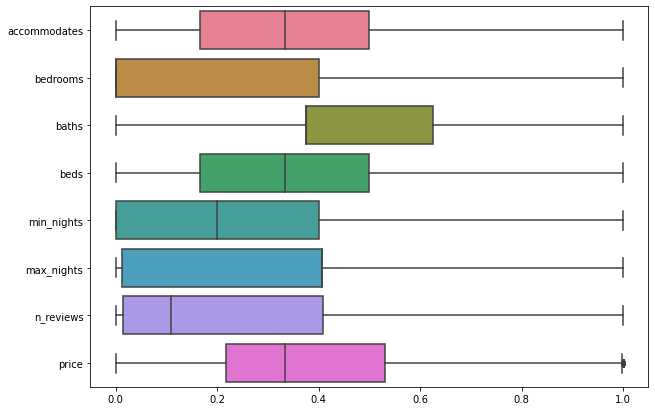

In [14]:
plt.figure(figsize=(10,7))
ax = sns.boxplot(data=chicago_2n, orient="h", palette="husl")

## 5. The Effect of Capping the Target Attribute

In [ ]:
import scipy.stats as stats

def diagnostic_plots(df, variable):   
    plt.figure(figsize=(16, 4))
   
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')
   
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Price Quantiles')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

# before capping outliers
diagnostic_plots(chicago, 'price')

In [ ]:
# after capping outliers
diagnostic_plots(chicago_2, 'price')

In [ ]:
chicago_2['price'].value_counts().head()

In [ ]:
IQR = chicago['price'].quantile(0.75) - chicago['price'].quantile(0.25)
LB = chicago['price'].quantile(0.25) - (IQR*1.5)
UB = chicago['price'].quantile(0.75) + (IQR*1.5)
LB, UB

In [ ]:
# remove upper boundary values
chicago_3 = chicago_2[chicago_2['price']!=299.375]
print(chicago_3.shape)
chicago_3['price'].value_counts().head()

In [ ]:
diagnostic_plots(chicago_3, 'price')

## 6. Train_Test Split and Scaling

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(chicago_3, test_size=0.2, random_state=42)
train.shape, test.shape

X_train = train.drop('price', axis=1)
y_train = train['price']

X_test = test.drop('price', axis=1)
y_test = test['price']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
normalizer = MinMaxScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.fit_transform(X_test)

## 7. Training KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
kpar = {'n_neighbors': np.arange(1, 21, 2),
       'weights': ['uniform', 'distance'],
       'algorithm': ['ball_tree', 'kd_tree', 'brute'],
       'p': [1,2]
      }
kgrid = GridSearchCV(knn, kpar, n_jobs=-1, cv=10)
kgrid.fit(X_train, y_train)     

print('Best Parameters:', kgrid.best_params_)
print('Best Score:', kgrid.best_score_)

In [ ]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=17, 
                        p=1, weights='uniform')
knn_mse = cross_val_score(knn, X_train, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
knn_rmse = np.sqrt(np.absolute(knn_mse))
print('RMSE:', knn_rmse)
print('Avg_RMSE:', knn_rmse.mean())
print('Std_RMSE:', knn_rmse.std())

## 8. Training Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

ran = RandomForestRegressor()
ranpar = {'max_depth': [2, 4, 6, 8],
          'min_samples_leaf': [1, 2, 3, 4],
          'min_samples_split':[2, 3, 4, 5]
         }
rangrid = GridSearchCV(ran, ranpar, n_jobs=-1, cv=10)
rangrid.fit(X_train, y_train)

print('Best Parameters:', rangrid.best_params_)
print('Best Score:', rangrid.best_score_)

In [ ]:
ran = RandomForestRegressor(max_depth=8, min_samples_leaf=4,
                            min_samples_split=4)
ranfo_mse = cross_val_score(ran, X_train, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
ranfo_rmse = np.sqrt(np.absolute(ranfo_mse))
print('RMSE:', ranfo_rmse)
print('Avg_RMSE:', ranfo_rmse.mean())
print('Std_RMSE:', ranfo_rmse.std())

Now we are talking! The magic of dealing with outliers!

## 9. Random Forest on Test Data

In [ ]:
from sklearn.metrics import mean_squared_error

ran = RandomForestRegressor(max_depth=8, min_samples_leaf=4,
                            min_samples_split=4)
ran.fit(X_train, y_train)
y_pred = ran.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print('MSE_train:', mse)
print('RMSE_train:', rmse)

In [ ]:
y_pred = ran.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MSE_test:', mse)
print('RMSE_test:', rmse)

## 10. KNN on Test Data

In [ ]:
knn = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=17, 
                        p=1, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print('MSE_train:', mse)
print('RMSE_train:', rmse)

In [ ]:
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MSE_test:', mse)
print('RMSE_test:', rmse)

It looks like `KNN` is doing better than `Random Forest` on the test data (which both have not seen) and, therefore, it is our best model. 

### Conclusion:
- Beware of outliers especially in the target attribute. They can cause pain because you models will be trying to replicate their effect during prediction
- Best Models:
    1. **K-Nearest Neighbor**: 
        - RMSE train = 44.4
        - **RMSE test = 45.4**
    2. Random Forest:
        - RMSE train = 42.4
        - RMSE test = 58.1